The purpose of this notebook is to create a prediction model, which takes into account the metadata about patient and the samples as the ECG curves. Targets for the model will be superclasses as defined by the dataset.

Superclasses enumerated by dataset description are as follows:
```
Records | Superclass | Description
9528 | NORM | Normal ECG
5486 | MI | Myocardial Infarction
5250 | STTC | ST/T Change
4907 | CD | Conduction Disturbance
2655 | HYP | Hypertrophy
```

In [ ]:
!pip install wfdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 6.1 MB/s eta 0:00:00


In [ ]:
import os
import ast
import wfdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow.keras as keras

sns.set_style('darkgrid')

First of all I need to load metadata about patients and samples provided by dataset. All metadata will be loaded to **ECG_df** and **SCP_df** dataframes respectively.

In [ ]:
!kaggle datasets download -d khyeh0719/ptb-xl-dataset

Dataset URL: https://www.kaggle.com/datasets/khyeh0719/ptb-xl-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
100% 1.72G/1.72G [00:28<00:00, 120MB/s]
100% 1.72G/1.72G [00:28<00:00, 64.4MB/s]


In [ ]:
import zipfile
import os

zip_file_path = '/content/ptb-xl-dataset.zip'
extract_path = '/kaggle/working/ptb-xl-dataset/'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
PATH_TO_DATA = '/kaggle/working/ptb-xl-dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'

ECG_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'ptbxl_database.csv'), index_col='ecg_id')
ECG_df.scp_codes = ECG_df.scp_codes.apply(lambda x: ast.literal_eval(x))
ECG_df.patient_id = ECG_df.patient_id.astype(int)
ECG_df.nurse = ECG_df.nurse.astype('Int64')
ECG_df.site = ECG_df.site.astype('Int64')
ECG_df.validated_by = ECG_df.validated_by.astype('Int64')

SCP_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'scp_statements.csv'), index_col=0)
SCP_df = SCP_df[SCP_df.diagnostic == 1]

ECG_df

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709,56.0,1,NaN,63.0,2,0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
2,13243,19.0,0,NaN,70.0,2,0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
3,20372,37.0,1,NaN,69.0,2,0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
4,17014,24.0,0,NaN,82.0,2,0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
5,17448,19.0,1,NaN,70.0,2,0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,17180,67.0,1,NaN,NaN,1,2,AT-60 3,2001-05-31 09:14:35,ventrikulÄre extrasystole(n) sinustachykardie ...,...,True,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr
21834,20703,93.0,0,NaN,NaN,1,2,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,...,True,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr
21835,19311,59.0,1,NaN,NaN,1,2,AT-60 3,2001-06-08 10:30:27,sinusrhythmus lagetyp normal t abnorm in anter...,...,True,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr


In [ ]:
ECG_df = ECG_df[(ECG_df['age'] >= 10) & (ECG_df['age'] < 40)].reset_index(drop=True)
ECG_df

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,13243,19.0,0,NaN,70.0,2,0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
1,20372,37.0,1,NaN,69.0,2,0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
2,17014,24.0,0,NaN,82.0,2,0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
3,17448,19.0,1,NaN,70.0,2,0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr
4,19005,18.0,1,NaN,58.0,2,0,CS-12 E,1984-11-28 13:32:13,sinusrhythmus normales ekg,...,True,", V1",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00006_lr,records500/00000/00006_hr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830,20990,37.0,1,NaN,NaN,0,0,CS100 3,2001-01-20 15:49:14,sinusrhythmus lagetyp normal normales ekg 4.46...,...,False,NaN,", I-AVF,",NaN,NaN,NaN,NaN,2,records100/21000/21744_lr,records500/21000/21744_hr
2831,11171,28.0,0,NaN,NaN,0,0,CS100 3,2001-01-23 10:30:00,sinusrhythmus lagetyp normal normales ekg 4.46...,...,False,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21758_lr,records500/21000/21758_hr
2832,16077,22.0,1,NaN,NaN,0,0,CS100 3,2001-01-27 11:43:56,sinus arrhythmie lagetyp normal unspezifisches...,...,False,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21770_lr,records500/21000/21770_hr
2833,17583,35.0,1,NaN,NaN,0,0,CS100 3,2001-01-29 14:09:14,"sinusrhythmus linkstyp st & t abnorm, wahrsche...",...,False,NaN,", I-AVR,",NaN,NaN,NaN,NaN,4,records100/21000/21787_lr,records500/21000/21787_hr


ECG samples are strattified to 10 groups. The authors of PTB-XL ECG dataset suggest use first 8 groups as the training samples. Last two groups then use as the validation and test sample set.
I will accept this suggestion on my following work.

In [ ]:
ECG_df.strat_fold.value_counts()

,count
strat_fold,
5,285
7,285
1,284
4,284
9,284
6,284
10,283
3,283
8,282


I am going to add one more column **scp_classes** to ECG_df dataset, which represents all superlasses (as a list of abbreviations) assigned to the sample by cardiologists.

In [ ]:
def diagnostic_class(scp):
    res = set()
    for k in scp.keys():
        if k in SCP_df.index:
            res.add(SCP_df.loc[k].diagnostic_class)
    return list(res)

ECG_df['scp_classes'] = ECG_df.scp_codes.apply(diagnostic_class)

And finally I am going to load row data (ECG curves) to **ECG_data** dataset.

In [ ]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(os.path.join(path, f)) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(os.path.join(path, f)) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

sampling_rate = 100

ECG_data = load_raw_data(ECG_df, sampling_rate, PATH_TO_DATA)

ECG_data.shape

(2835, 1000, 12)

Now I have all data from **PTB-XL ECG dataset** loaded to Pandas dataframes or numpy arrays. So I can take a short look at them.

I do not want linger on data analysis for a long time. Very good job was already done by colleagues at [PTB XL Dataset Wrangling](https://www.kaggle.com/code/khyeh0719/ptb-xl-dataset-wrangling) notebook.

As an example I would like to show only one sample from ECG_data dataset:

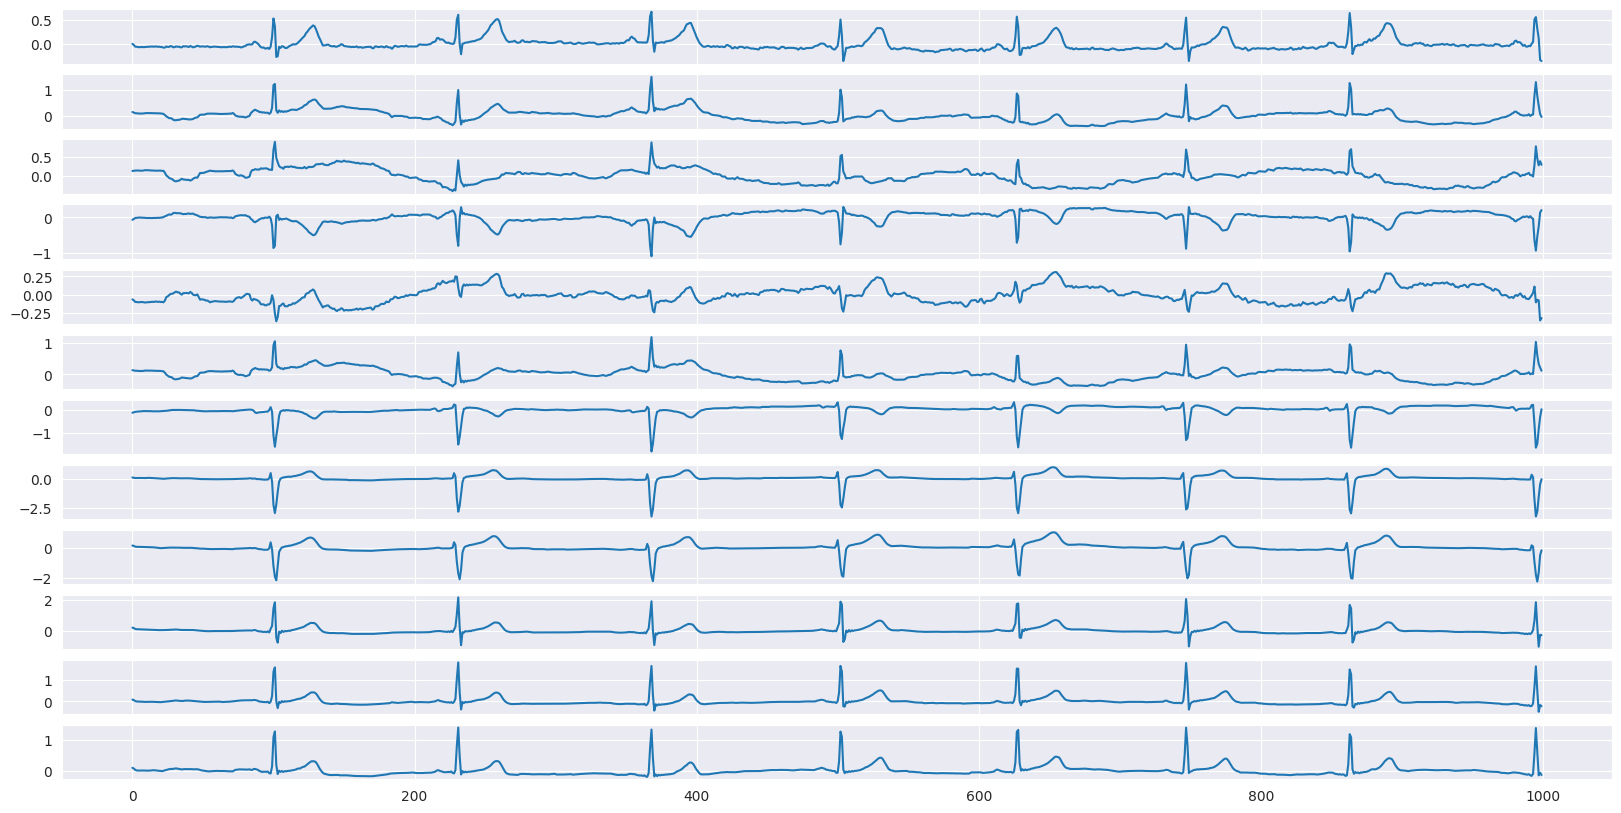

In [ ]:
sample = ECG_data[0]
bar, axes = plt.subplots(sample.shape[1], 1, figsize=(20,10))
for i in range(sample.shape[1]):
    sns.lineplot(x=np.arange(sample.shape[0]), y=sample[:, i], ax=axes[i])
# plt.tight_layout()
plt.show()

First problem, I would like to cope with, are null values in metadata dataframe. There is a quick look at the problem:

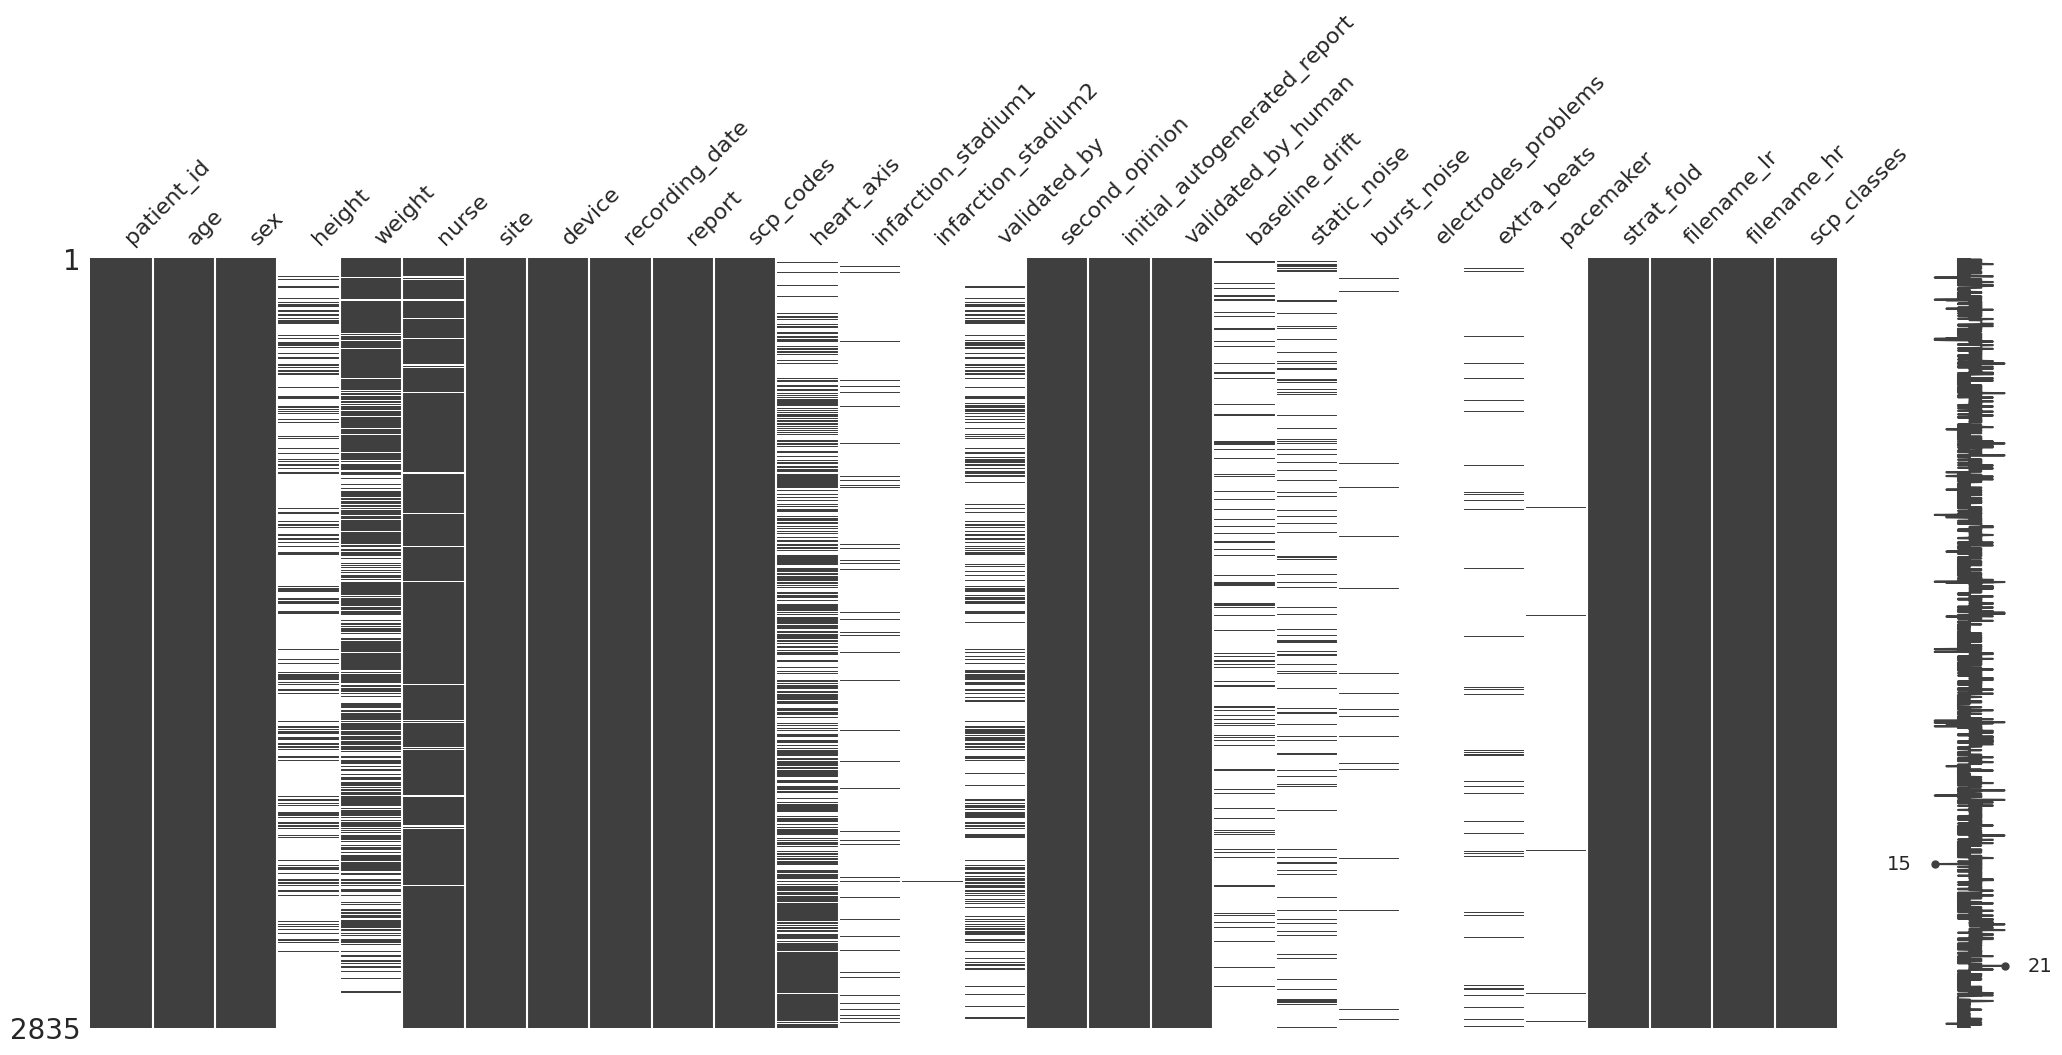

In [ ]:
import missingno as msno

msno.matrix(ECG_df)
plt.show()

And to add another angle of the view, there is an overview of unique values in all columns of metadata dataframe:

In [ ]:
ECG_df[[col for col in ECG_df.columns if col not in ('scp_codes', 'scp_classes')]].nunique(dropna=True)

,0
patient_id,2596
age,30
sex,2
height,52
weight,90
nurse,12
site,31
device,11
recording_date,2834
report,792


# Data preparation for modeling

I need first prepare input and output (targets) for my models.

As inputs I will use both patient metadata (now loaded in the ECG_df dataframe) and ECG curves (in the ECG_data numpy array) respectively. But both require some rework to be useful for modeling, which will be done in following few steps.

As outputs I will create new dataframe with rows equal to samples and columns corresponding with diagnosis superclasses.

Because I will have two inputs and one output, I will preffix all created dataframes as follows:
- X - prefix for patient and sample metadata
- Y - prefix for ECG curves
- Z - prefix for targets

## X dataframe ...

I won't use all columns from ECG_df dataframe, but only a subset of them.
Created dataframe **X** comprises only columns, witch are related to patient and his health condition. During dataframe creation I will cope with null values and mapping categorical columns to numerical representation.

In [ ]:
X = pd.DataFrame(index=ECG_df.index)

X['age'] = ECG_df.age
X.age.fillna(0, inplace=True)

X['sex'] = ECG_df.sex.astype(float)
X.sex.fillna(0, inplace=True)

X['height'] = ECG_df.height
X.loc[X.height < 50, 'height'] = np.nan
X.height.fillna(0, inplace=True)

X['weight'] = ECG_df.weight
X.weight.fillna(0, inplace=True)

X['infarction_stadium1'] = ECG_df.infarction_stadium1.replace({
    'unknown': 0,
    'Stadium I': 1,
    'Stadium I-II': 2,
    'Stadium II': 3,
    'Stadium II-III': 4,
    'Stadium III': 5
}).fillna(0)

X['infarction_stadium2'] = ECG_df.infarction_stadium2.replace({
    'unknown': 0,
    'Stadium I': 1,
    'Stadium II': 2,
    'Stadium III': 3
}).fillna(0)

X['pacemaker'] = (ECG_df.pacemaker == 'ja, pacemaker').astype(float)

X

<ipython-input-17-494dc8d5c6e4>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X.age.fillna(0, inplace=True)
<ipython-input-17-494dc8d5c6e4>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: 

,age,sex,height,weight,infarction_stadium1,infarction_stadium2,pacemaker
0,19.0,0.0,0.0,70.0,0.0,0.0,0.0
1,37.0,1.0,0.0,69.0,0.0,0.0,0.0
2,24.0,0.0,0.0,82.0,0.0,0.0,0.0
3,19.0,1.0,0.0,70.0,0.0,0.0,0.0
4,18.0,1.0,0.0,58.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
2830,37.0,1.0,0.0,0.0,0.0,0.0,0.0
2831,28.0,0.0,0.0,0.0,0.0,0.0,0.0
2832,22.0,1.0,0.0,0.0,0.0,0.0,0.0
2833,35.0,1.0,0.0,0.0,0.0,0.0,0.0


## Y dataframe ...

At present I do not need to change data in the ECF_data dataframe, so I will use it as is.

## Z targets ...

I am going to create **Z** dataframe with columns corresponding to diagnoses superclasses.

In [ ]:
Z = pd.DataFrame(0, index=ECG_df.index, columns=['NORM', 'MI', 'STTC', 'CD', 'HYP'], dtype='int')
for i in Z.index:
    for k in ECG_df.loc[i].scp_classes:
        Z.loc[i, k] = 1

Z

,NORM,MI,STTC,CD,HYP
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
2830,1,0,0,0,0
2831,1,0,0,0,0
2832,0,0,1,0,0
2833,0,0,1,0,0


In [ ]:
label_counts = Z.sum()
print(label_counts)

NORM    2289
MI       130
STTC     201
CD       316
HYP      130
dtype: int64


## Splitting to train, validate and test datasets

As the authors of PTB-XL ECG dataset suggest, I will split all input and output dataset to training, validation and test subsets according *strat_fold* column.

In [ ]:
X_train, Y_train, Z_train = X[ECG_df.strat_fold <= 8],  ECG_data[X[ECG_df.strat_fold <= 8].index - 1],  Z[ECG_df.strat_fold <= 8]
X_valid, Y_valid, Z_valid = X[ECG_df.strat_fold == 9],  ECG_data[X[ECG_df.strat_fold == 9].index - 1],  Z[ECG_df.strat_fold == 9]
X_test,  Y_test,  Z_test  = X[ECG_df.strat_fold == 10], ECG_data[X[ECG_df.strat_fold == 10].index - 1], Z[ECG_df.strat_fold == 10]

print(X_train.shape, Y_train.shape, Z_train.shape)
print(X_valid.shape, Y_valid.shape, Z_valid.shape)
print(X_test.shape,  Y_test.shape,  Z_test.shape)

(2268, 7) (2268, 1000, 12) (2268, 5)
(284, 7) (284, 1000, 12) (284, 5)
(283, 7) (283, 1000, 12) (283, 5)


## Standardization of all input datasets

Wise people sometimes recommend to normalize/standardize data before using them for modeling and predictions. I will obey their opinions.

In [ ]:
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()
X_scaler.fit(X_train)

X_train = pd.DataFrame(X_scaler.transform(X_train), columns=X_train.columns)
X_valid = pd.DataFrame(X_scaler.transform(X_valid), columns=X_valid.columns)
X_test  = pd.DataFrame(X_scaler.transform(X_test),  columns=X_test.columns)

In [ ]:
Y_scaler = StandardScaler()
Y_scaler.fit(Y_train.reshape(-1, Y_train.shape[-1]))

Y_train = Y_scaler.transform(Y_train.reshape(-1, Y_train.shape[-1])).reshape(Y_train.shape)
Y_valid = Y_scaler.transform(Y_valid.reshape(-1, Y_valid.shape[-1])).reshape(Y_valid.shape)
Y_test  = Y_scaler.transform(Y_test.reshape(-1, Y_test.shape[-1])).reshape(Y_test.shape)

## Save all data to NPZ file

All previous steps took some time to complete. Loading all raw data is usually time consuming. So I decided to store all prepared data to file and use them later for my experiments with different models.

In [ ]:
NUMPY_DATA_FILE = '/kaggle/working/data.npz'

save_args = {
    'X_train': X_train.to_numpy().astype('float32'),
    'X_valid': X_valid.to_numpy().astype('float32'),
    'X_test':  X_test.to_numpy().astype('float32'),
    'Y_train': Y_train.astype('float32'),
    'Y_valid': Y_valid.astype('float32'),
    'Y_test':  Y_test.astype('float32'),
    'Z_train': Z_train.to_numpy().astype('float32'),
    'Z_valid': Z_valid.to_numpy().astype('float32'),
    'Z_test':  Z_test.to_numpy().astype('float32'),
}
np.savez(NUMPY_DATA_FILE, **save_args)

# os.remove(NUMPY_DATA_FILE)

# Models for metadata and row ECG curves

Targets for all models will be diagnosis superclasses assigned to every sample. Due to the fact, that a single sample can be marked by one o more superclasses, I will look for a **multilabel classification**.
For evaluation how succesful I am with my models, I will use preferably **binary accuracy** metric.

In [ ]:
import sys
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as keras

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

sns.set_style('darkgrid')

I can read all prepared data at previous steps from NPZ file. This is useful, when I want to spare some work already done.

In [ ]:
NUMPY_DATA_FILE = '/kaggle/working/data.npz'

thismodule = sys.modules[__name__]

with np.load(NUMPY_DATA_FILE) as data:
    for k in data.keys():
        setattr(thismodule, k, data[k].astype(float))

## Reference Model Baseline

Before I dive into real modeling, I would like to make some naive models as a reference for later comparison.

First naive model I try to evaluate: all samples have assigned diagnosis superclass "NORM" due to this class is most often represented.

In [ ]:
z1 = np.zeros(Z_test.shape)
z1[:, 0] = 1

m = keras.metrics.BinaryAccuracy()
m.update_state(Z_test, z1)
m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.91519433>

And the second reference model: all samples have assigned superlasses according to the probability of their representation in the train subset.

In [ ]:
z_prob = Z_train.sum(axis=0) / Z_train.shape[0]
z2 = np.random.uniform(size=Z_test.shape)

for i in range(z2.shape[-1]):
    z2[:, i] = (z2[:, i] < z_prob[i]).astype('float64')

m = keras.metrics.BinaryAccuracy()
m.update_state(Z_test, z2)
m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.82968205>

## X Classifier

This is the first model, I would like to evalute. I try to make prediction based on patient and sample metadata - X dataset.

The model is quite simple. It is composed of two fully connected Dense layers supplemented by Dropoout regularization layers. I will use this model on my later work, so it will be wise to prepare a function for it:

In [ ]:
def create_X_model(X, *, units=32, dropouts=0.3):

    X = keras.layers.Dense(units, activation='relu', name='X_dense_1')(X)
    X = keras.layers.Dropout(dropouts, name='X_drop_1')(X)
    X = keras.layers.Dense(units, activation='relu', name='X_dense_2')(X)
    X = keras.layers.Dropout(dropouts, name='X_drop_2')(X)

    return X

I would like to evaluate it, so I need complete model with additional Dense layers, regularization and final Dense layer with *sigmoid* activation function.

In [ ]:
def create_model01(X_shape, Z_shape):
    X_inputs = keras.Input(X_shape[1:], name='X_inputs')

    X = create_X_model(X_inputs)
    X = keras.layers.Dense(64, activation='relu', name='Z_dense_1')(X)
    X = keras.layers.Dense(64, activation='relu', name='Z_dense_2')(X)
    X = keras.layers.Dropout(0.5, name='Z_drop_1')(X)
    outputs = keras.layers.Dense(Z_shape[-1], activation='sigmoid', name='Z_outputs')(X)

    model = keras.Model(inputs=X_inputs, outputs=outputs, name='model01')
    return model

Next few steps are stright forward. The **model01** is created, compiled and presented as a summary ...

In [ ]:
model01 = create_model01(X_train.shape, Z_train.shape)
model01.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', 'Precision', 'Recall'])
model01.summary()

Model: "model01"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ X_inputs (InputLayer)                │ (None, 7)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ X_dense_1 (Dense)                    │ (None, 32)                  │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ X_drop_1 (Dropout)                   │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ X_dense_2 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ X_drop_2 (Dropout)                   │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Z_dense_1 (Dense)                    │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Z_dense_2 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Z_drop_1 (Dropout)                   │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Z_outputs (Dense)                    │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,909 (30.89 KB)

 Trainable params: 7,909 (30.89 KB)

 Non-trainable params: 0 (0.00 B)

Model fitting will be stopped, when it ceases to improve. Then model with best results is read from checkpoint file.

In [ ]:
MODEL_CHECKPOINT = '/kaggle/working/model/model01.keras'

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=10),
    keras.callbacks.ModelCheckpoint(filepath=MODEL_CHECKPOINT, monitor='val_binary_accuracy', save_best_only=True)
]

history = model01.fit(X_train, Z_train, epochs=40, batch_size=32, callbacks=callbacks_list, validation_data=(X_valid, Z_valid))

model01 = keras.models.load_model(MODEL_CHECKPOINT)

Epoch 1/40
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - Precision: 0.5017 - Recall: 0.6802 - binary_accuracy: 0.7667 - loss: 0.5621 - val_Precision: 0.8134 - val_Recall: 0.7549 - val_binary_accuracy: 0.9099 - val_loss: 0.2949
Epoch 2/40
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - Precision: 0.8095 - Recall: 0.7463 - binary_accuracy: 0.9075 - loss: 0.3333 - val_Precision: 0.8134 - val_Recall: 0.7549 - val_binary_accuracy: 0.9099 - val_loss: 0.2790
Epoch 3/40
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Precision: 0.8086 - Recall: 0.7393 - binary_accuracy: 0.9053 - loss: 0.3145 - val_Precision: 0.8191 - val_Recall: 0.7549 - val_binary_accuracy: 0.9113 - val_loss: 0.2765
Epoch 4/40
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Precision: 0.8180 - Recall: 0.7399 - binary_accuracy: 0.9081 - loss: 0.2868 - val_Precision: 0.8185 - val_Recall: 0.7516 - val_binary_accuracy: 0.9106 - val_loss: 0.2708
Epoch 5/40
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.8048 - Recall: 0.7238 - binary_accuracy: 0.90

And finally you can see the fitting history with loss functions and metrics:

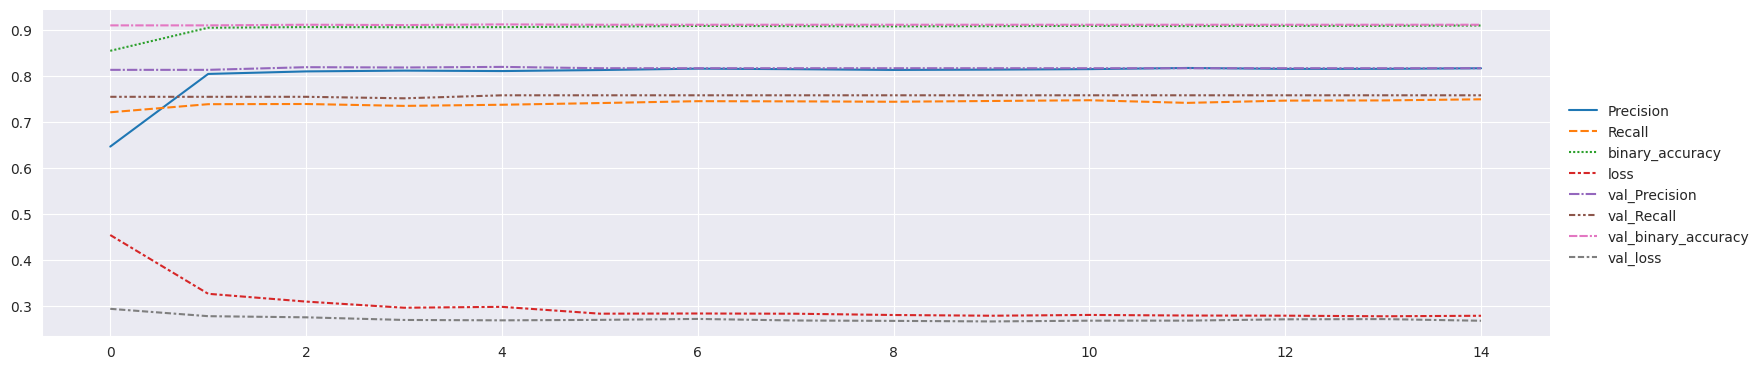

In [ ]:
sns.relplot(data=pd.DataFrame(history.history), kind='line', height=4, aspect=4)
plt.show()

I try to evaluate the model agains test dataset. As you can see, I can get better results than from naive models. So this is not the best result I can get, but it is useful.

In [ ]:
model01.evaluate(X_test, Z_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - Precision: 0.8130 - Recall: 0.7441 - binary_accuracy: 0.9066 - loss: 0.2908


[0.2668312191963196,
 0.9166077375411987,
 0.8374558091163635,
 0.7669903039932251]

## X and Y: 1D CNN Classifier

Now I am on the essention point of my work, 1D Convolution model for ECG curves improved by model for metadata.

First I need a model for curves. Once again it is a function, which creates three Conv1D layers supplemented by normalization and activation layers. Layers are separated by MaxPool1D layers, which reduce timeseries dimension of the input tensor. On the other side, Conv1D layers have growing number of filters, so the feature dimension is expanding. Whole model is finalized by GlobalAveragePooling1D layer (only features matter) and Dropout regularization.

And there is the function:

In [ ]:
def create_Y_model(X, *, filters=(32, 64, 128), kernel_size=(5, 3, 3), strides=(1, 1, 1)):

    f1, f2, f3 = filters
    k1, k2, k3 = kernel_size
    s1, s2, s3 = strides

    X = keras.layers.Conv1D(f1, k1, strides=s1, padding='same', name='Y_conv_1')(X)
    X = keras.layers.BatchNormalization(name='Y_norm_1')(X)
    X = keras.layers.ReLU(name='Y_relu_1')(X)

    X = keras.layers.MaxPool1D(2, name='Y_pool_1')(X)

    X = keras.layers.Conv1D(f2, k2, strides=s2, padding='same', name='Y_conv_2')(X)
    X = keras.layers.BatchNormalization(name='Y_norm_2')(X)
    X = keras.layers.ReLU(name='Y_relu_2')(X)

    X = keras.layers.MaxPool1D(2, name='Y_pool_2')(X)

    X = keras.layers.Conv1D(f3, k3, strides=s3, padding='same', name='Y_conv_3')(X)
    X = keras.layers.BatchNormalization(name='Y_norm_3')(X)
    X = keras.layers.ReLU(name='Y_relu_3')(X)

    X = keras.layers.GlobalAveragePooling1D(name='Y_aver')(X)
    X = keras.layers.Dropout(0.5, name='Y_drop')(X)

    return X

I will now proceed to combine models for ECG curves and patient metadata to one all encompassing model.

There are two imputs, X and Y datasets, and one output Z. I will concatenate models for metadata and ECG curves. The concatenation result will be fed to two fully connected Dense layers, followed by Dropout and final Dense layer with *sigmoid* activation. And that is all.

In [ ]:
def create_model02(X_shape, Y_shape, Z_shape):
    X_inputs = keras.Input(X_shape[1:], name='X_inputs')
    Y_inputs = keras.Input(Y_shape[1:], name='Y_inputs')

    X = keras.layers.Concatenate(name='Z_concat')([create_X_model(X_inputs), create_Y_model(Y_inputs, filters=(64, 128, 256), kernel_size=(7, 3, 3))])
    X = keras.layers.Dense(64, activation='relu', name='Z_dense_1')(X)
    X = keras.layers.Dense(64, activation='relu', name='Z_dense_2')(X)
    X = keras.layers.Dropout(0.5, name='Z_drop_1')(X)
    outputs = keras.layers.Dense(Z_shape[-1], activation='sigmoid', name='Z_outputs')(X)

    model = keras.Model(inputs=[X_inputs, Y_inputs], outputs=outputs, name='model02')
    return model

I can create model **model02**, compile it, and show its summary:

In [ ]:
model02 = create_model02(X_train.shape, Y_train.shape, Z_train.shape)
model02.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', 'Precision', 'Recall'])
model02.summary()

Model: "model02"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Y_inputs (InputLayer)     │ (None, 1000, 12)       │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Y_conv_1 (Conv1D)         │ (None, 1000, 64)       │          5,440 │ Y_inputs[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Y_norm_1                  │ (None, 1000, 64)       │            256 │ Y_conv_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Y_relu_1 (ReLU)           │ (None, 1000, 64)       │              0 │ Y_norm_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Y_pool_1 (MaxPooling1D)   │ (None, 500, 64)        │              0 │ Y_relu_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Y_conv_2 (Conv1D)         │ (None, 500, 128)       │         24,704 │ Y_pool_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Y_norm_2                  │ (None, 500, 128)       │            512 │ Y_conv_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Y_relu_2 (ReLU)           │ (None, 500, 128)       │              0 │ Y_norm_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Y_pool_2 (MaxPooling1D)   │ (None, 250, 128)       │              0 │ Y_relu_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ X_inputs (InputLayer)     │ (None, 7)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Y_conv_3 (Conv1D)         │ (None, 250, 256)       │         98,560 │ Y_pool_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ X_dense_1 (Dense)         │ (None, 32)             │            256 │ X_inputs[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Y_norm_3                  │ (None, 250, 256)       │          1,024 │ Y_conv_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ X_drop_1 (Dropout)        │ (None, 32)             │              0 │ X_dense_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Y_relu_3 (ReLU)           │ (None, 250, 256)       │              0 │ Y_norm_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ X_dense_2 (Dense)         │ (None, 32)             │          1,056 │ X_drop_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Y_aver                    │ (None, 256)            │              0 │ Y_relu_3[0][0]         │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ X_drop_2 (Dropout)   

 Total params: 154,789 (604.64 KB)

 Trainable params: 153,893 (601.14 KB)

 Non-trainable params: 896 (3.50 KB)

Once again the model fitting is driven by early stopping and model checking callbacks. Following steps show fitting history and model evaluation against test dataset.

In [ ]:
MODEL_CHECKPOINT = '/kaggle/working/model/model02.keras'

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=20),
    keras.callbacks.ModelCheckpoint(filepath=MODEL_CHECKPOINT, monitor='val_binary_accuracy', save_best_only=True)
]

history = model02.fit([X_train, Y_train], Z_train, epochs=100, batch_size=32, callbacks=callbacks_list, validation_data=([X_valid, Y_valid], Z_valid))

model02 = keras.models.load_model(MODEL_CHECKPOINT)

Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - Precision: 0.6304 - Recall: 0.7051 - binary_accuracy: 0.8360 - loss: 0.4324 - val_Precision: 0.8134 - val_Recall: 0.7549 - val_binary_accuracy: 0.9099 - val_loss: 0.3334
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - Precision: 0.8130 - Recall: 0.7398 - binary_accuracy: 0.9071 - loss: 0.3134 - val_Precision: 0.8163 - val_Recall: 0.7549 - val_binary_accuracy: 0.9106 - val_loss: 0.3132
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Precision: 0.7981 - Recall: 0.7300 - binary_accuracy: 0.9025 - loss: 0.3086 - val_Precision: 0.8185 - val_Recall: 0.7516 - val_binary_accuracy: 0.9106 - val_loss: 0.2810
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.8121 - Recall: 0.7294 - binary_accuracy: 0.9043 - loss: 0.2999 - val_Precision: 0.8191 - val_Recall: 0.7549 - val_binary_accuracy: 0.9113 - val_loss: 0.2856
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Precision: 0.8198 - Recall: 0.7482 - binary_accurac

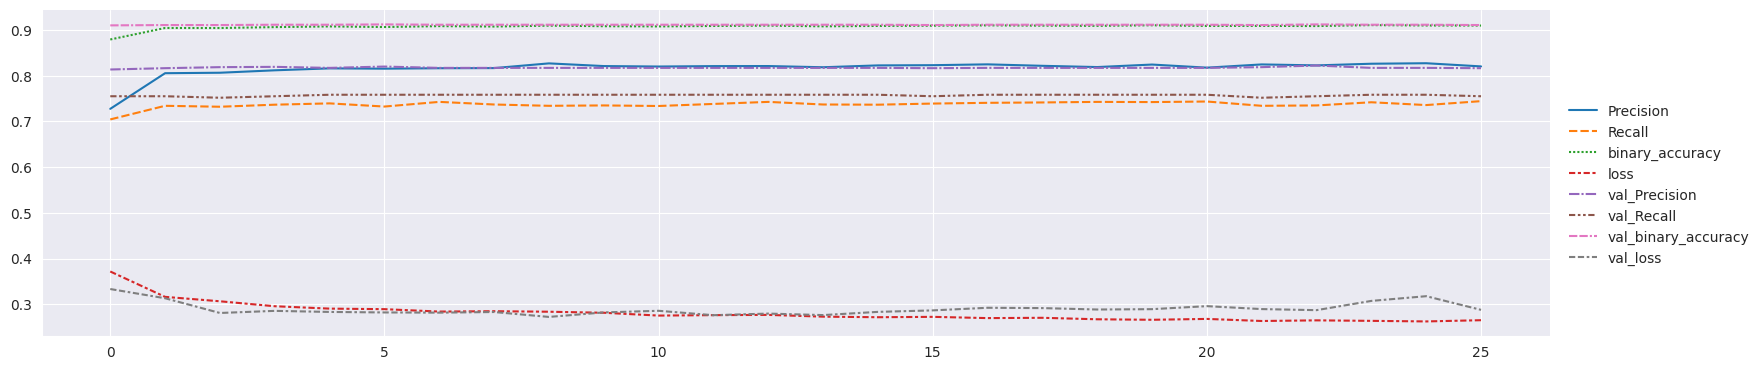

In [ ]:
sns.relplot(data=pd.DataFrame(history.history), kind='line', height=4, aspect=4)
plt.show()

In [ ]:
model02.evaluate([X_test, Y_test], Z_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - Precision: 0.8130 - Recall: 0.7441 - binary_accuracy: 0.9066 - loss: 0.2932


[0.26844322681427, 0.9166077375411987, 0.8374558091163635, 0.7669903039932251]

## Final comments regarding models of X and Y

**I have achived 0.89 binary accuracy.**


What I have tried in the course of my work:

- change layers number and units count for the metadata model
- change layers number and units count for ECG curves model
- different pooling and regularizations for ECG curves model
- models based on ResNet architecture with respect to timeseries data, but I failed to achieve better results


# ECG signals augmentation during training

One of possibilities, how I could improve prediction results, is trying augmentation of ECG signals during training phase.
I hope that my model will be able to improve for significantly more epochs.

I will give it a try and will see ...

First of all I need augmented sources of training, validation and test data respectively. For this purpose I will prepare generator derived from Keras Sequence class.

What I would like to do in the generator:
- sliding window of ECG signals
- noise added to ECG signals

If you look at the ECG signals then you see, that these are periodical signals with random beginning. So I try to randomly choose a fix-length window of sample signals - I call this "sliding window".

Generator has two parameters regarding sliding window:
- ```window_size``` - width of time-series window
- ```window_shift``` - if less than 0 then random shifting otherwise shifting by fixed value

Another augmentation of the ECG sample signals is adding a noise to all curves. I will use normal distribution with mean equal to zero and deviation equal to parameter ```sigma```.

In [ ]:
def sliding_window(x, size, shift):
    if 0 < size < x.shape[0]:
        shift = np.random.randint(0, x.shape[0] - size) if shift < 0 else shift
        return x[shift:size+shift, :]
    else:
        return x


class AugmentedDataGenerator(keras.utils.Sequence):

    def __init__(self, x, y, z, batch_size=32, window_size=0, window_shift=0, sigma=0.0, **kwargs):
        super(AugmentedDataGenerator, self).__init__(**kwargs)
        self.x = x
        self.y = y
        self.z = z
        self.batch_size = batch_size
        self.window_size = window_size
        self.window_shift = window_shift
        self.sigma = sigma

    @property
    def x_shape(self):
        return (self.batch_size, ) + self.x.shape[1:]

    @property
    def y_shape(self):
        return (self.batch_size, self.window_size if self.window_size > 0 else self.y.shape[1], ) + self.y.shape[2:]

    @property
    def z_shape(self):
        return (self.batch_size, ) + self.z.shape[1:]

    def __len__(self):
        return math.ceil(len(self.y) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = np.array([sliding_window(r, self.window_size, self.window_shift) for r in self.y[idx * self.batch_size:(idx + 1) * self.batch_size]])
        batch_z = self.z[idx * self.batch_size:(idx + 1) * self.batch_size]

        if self.sigma > 0:
            batch_y += np.random.normal(loc=0.0, scale=self.sigma, size=batch_y.shape)

        return (batch_x, batch_y), batch_z

I will need further three instances of generator, namely for training, validation and test purpopses.

Generator for training will provide 800 points sliding windows with random shifting of the window. In addition then adding noise to every ECG curve in the window.

Other two generators for validation and test purposes will provide 800 points sliding windows without shifting and noise.

In [ ]:
train_gen = AugmentedDataGenerator(X_train, Y_train, Z_train, window_size=800, window_shift=-1, sigma=0.05)
valid_gen = AugmentedDataGenerator(X_valid, Y_valid, Z_valid, window_size=800)
test_gen  = AugmentedDataGenerator(X_test, Y_test, Z_test, window_size=800)

Here is a short look at one augmented sample:

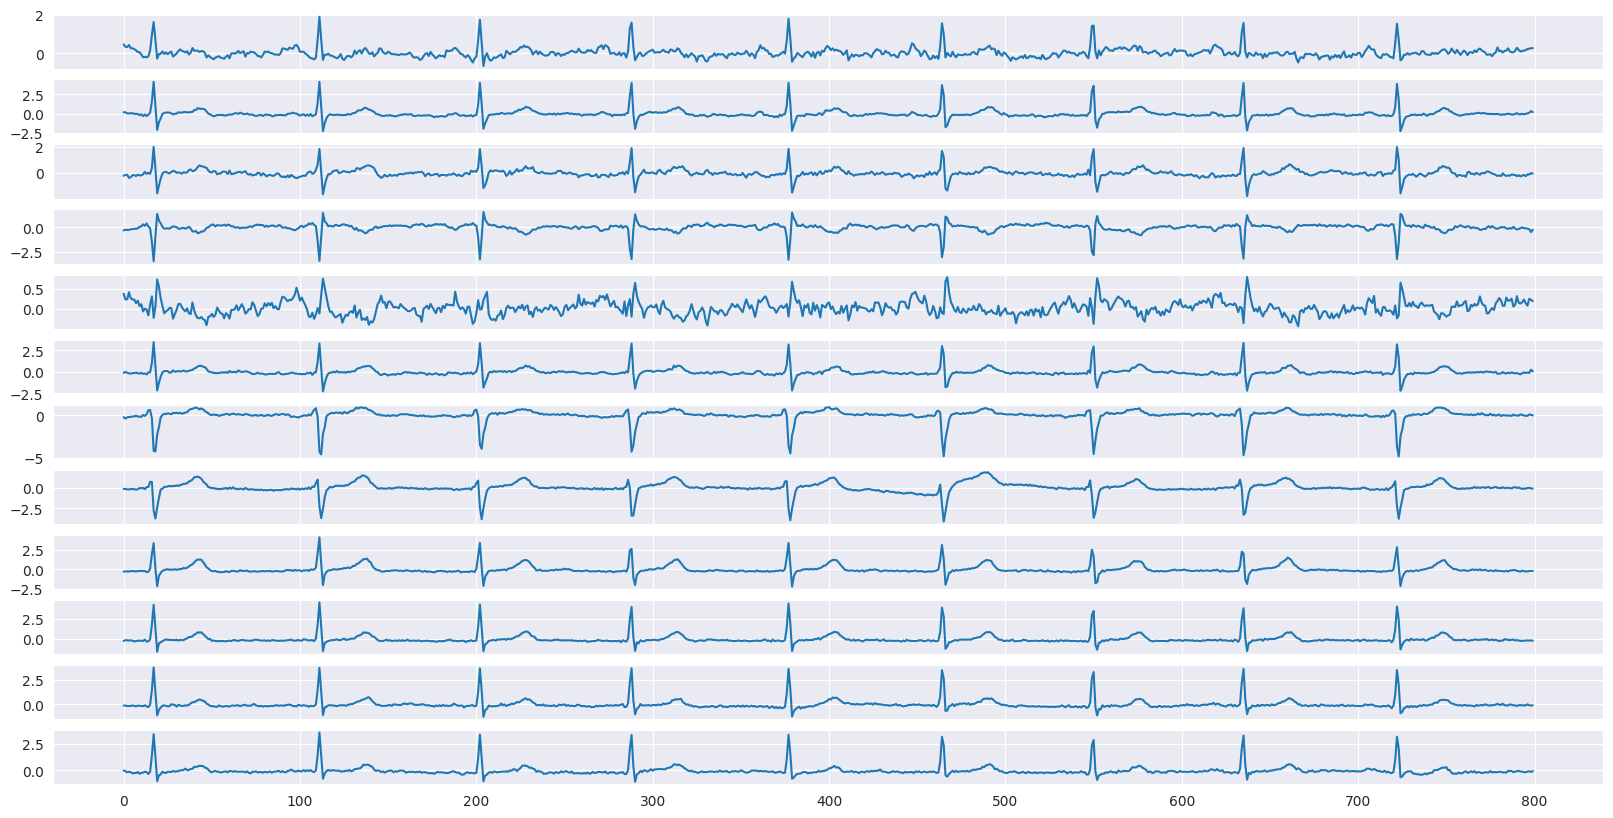

In [ ]:
(x, y), z = train_gen[0]
sample = y[0]
bar, axes = plt.subplots(sample.shape[1], 1, figsize=(20,10))
for i in range(sample.shape[1]):
    sns.lineplot(x=np.arange(sample.shape[0]), y=sample[:, i], ax=axes[i])
# plt.tight_layout()
plt.show()

Model is the same as before. I will use the same function ```create_model02``` for its instantiation.

In [ ]:
model03 = create_model02(train_gen.x_shape, train_gen.y_shape, train_gen.z_shape)
model03.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', 'Precision', 'Recall'])
model03.summary()

Model: "model02"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Y_inputs (InputLayer)     │ (None, 800, 12)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Y_conv_1 (Conv1D)         │ (None, 800, 64)        │          5,440 │ Y_inputs[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Y_norm_1                  │ (None, 800, 64)        │            256 │ Y_conv_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Y_relu_1 (ReLU)           │ (None, 800, 64)        │              0 │ Y_norm_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Y_pool_1 (MaxPooling1D)   │ (None, 400, 64)        │              0 │ Y_relu_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Y_conv_2 (Conv1D)         │ (None, 400, 128)       │         24,704 │ Y_pool_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Y_norm_2                  │ (None, 400, 128)       │            512 │ Y_conv_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Y_relu_2 (ReLU)           │ (None, 400, 128)       │              0 │ Y_norm_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Y_pool_2 (MaxPooling1D)   │ (None, 200, 128)       │              0 │ Y_relu_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ X_inputs (InputLayer)     │ (None, 7)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Y_conv_3 (Conv1D)         │ (None, 200, 256)       │         98,560 │ Y_pool_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ X_dense_1 (Dense)         │ (None, 32)             │            256 │ X_inputs[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Y_norm_3                  │ (None, 200, 256)       │          1,024 │ Y_conv_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ X_drop_1 (Dropout)        │ (None, 32)             │              0 │ X_dense_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Y_relu_3 (ReLU)           │ (None, 200, 256)       │              0 │ Y_norm_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ X_dense_2 (Dense)         │ (None, 32)             │          1,056 │ X_drop_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Y_aver                    │ (None, 256)            │              0 │ Y_relu_3[0][0]         │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ X_drop_2 (Dropout)   

 Total params: 154,789 (604.64 KB)

 Trainable params: 153,893 (601.14 KB)

 Non-trainable params: 896 (3.50 KB)

And now I will try to fit the model to augmented training data:

In [ ]:
MODEL_CHECKPOINT = '/kaggle/working/model/model03.keras'

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=20),
    keras.callbacks.ModelCheckpoint(filepath=MODEL_CHECKPOINT, monitor='val_binary_accuracy', save_best_only=True)
]

history = model03.fit(train_gen, epochs=100, batch_size=32, callbacks=callbacks_list, validation_data=valid_gen)

model03 = keras.models.load_model(MODEL_CHECKPOINT)

Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - Precision: 0.5017 - Recall: 0.6832 - binary_accuracy: 0.7621 - loss: 0.5031 - val_Precision: 0.8134 - val_Recall: 0.7549 - val_binary_accuracy: 0.9099 - val_loss: 0.3371
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - Precision: 0.7829 - Recall: 0.7023 - binary_accuracy: 0.8942 - loss: 0.3412 - val_Precision: 0.8134 - val_Recall: 0.7549 - val_binary_accuracy: 0.9099 - val_loss: 0.2899
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - Precision: 0.7911 - Recall: 0.7109 - binary_accuracy: 0.8954 - loss: 0.3230 - val_Precision: 0.8134 - val_Recall: 0.7549 - val_binary_accuracy: 0.9099 - val_loss: 0.2774
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - Precision: 0.8225 - Recall: 0.7507 - binary_accuracy: 0.9111 - loss: 0.2881 - val_Precision: 0.8163 - val_Recall: 0.7549 - val_binary_accuracy: 0.9106 - val_loss: 0.2791
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - Precision: 0.8347 - Recall: 0.7682 - binary_accu

Finally a short look at the results:

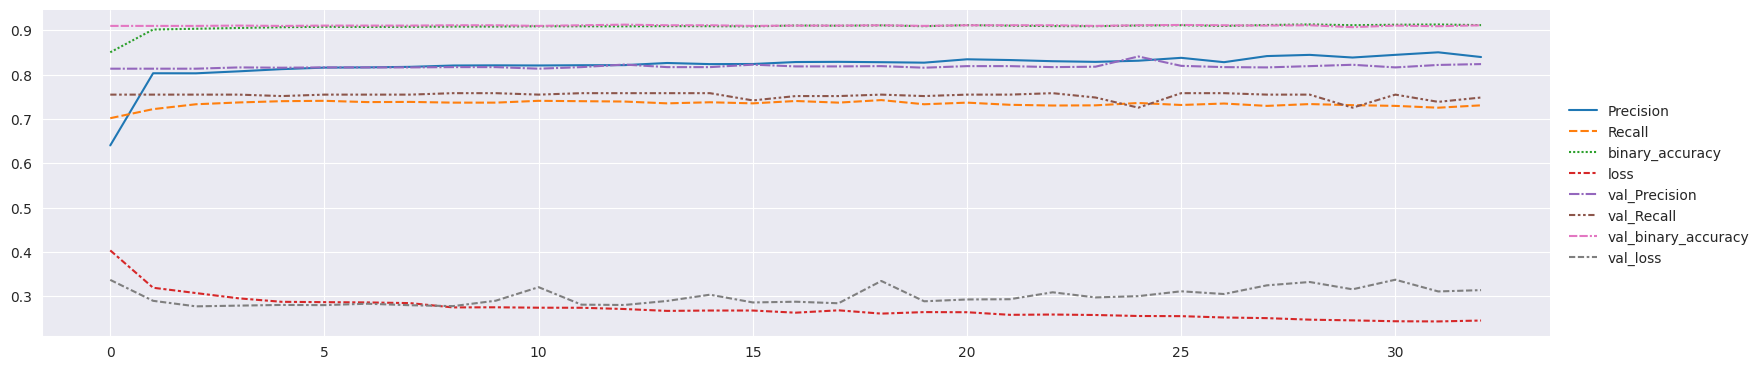

In [ ]:
sns.relplot(data=pd.DataFrame(history.history), kind='line', height=4, aspect=4)
plt.show()

In [ ]:
model03.evaluate(test_gen)

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - Precision: 0.8122 - Recall: 0.7368 - binary_accuracy: 0.9052 - loss: 0.2890


[0.26972833275794983,
 0.9159011244773865,
 0.8392857313156128,
 0.7605177760124207]

## Final comment regarding data augmentation

As you can see, my results are not better than previous results without data augmentation. So I am going to try something else and hope I will have more luck.

# A deeper evaluation of all my previous models

For now I would like to take a deeper look at my previous models and result, when they are applicated on test datasets.

As usual I need to load all my preprocessed data, but only test dataset will be used for models evaluation.

In [ ]:
import sys
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as keras

import sklearn.metrics

sns.set_style('darkgrid')

In [ ]:
NUMPY_DATA_FILE = '/kaggle/working/data.npz'

thismodule = sys.modules[__name__]

with np.load(NUMPY_DATA_FILE) as data:
    for k in data.keys():
        setattr(thismodule, k, data[k].astype(float))

This is auxiliary function for printing Confusion maps:

In [ ]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Class - " + class_label)

Now I am going to load all my models. They were saved during training phases as the ones with the best results. Subsequently I will predict results for test datasets.

In [ ]:
model01 = keras.models.load_model('/kaggle/working/model/model01.keras')
model02 = keras.models.load_model('/kaggle/working/model/model02.keras')
model03 = keras.models.load_model('/kaggle/working/model/model03.keras')

labels=['NORM', 'MI', 'STTC', 'CD', 'HYP']

Z_test = Z_test.astype(int)
Z_pred_01 = model01.predict(X_test).round().astype(int)
Z_pred_02 = model02.predict([X_test, Y_test]).round().astype(int)
Z_pred_03 = model03.predict([X_test, Y_test[:, :800, :]]).round().astype(int)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


## Confusion Matrix and Classification Report for model01

And there is the detailed view of resuts for model01. You can see the confusion maps for all labels and the classification report.

This is the first model, which try to predict targets using metadata dataset only - X dataset. As you can see, I am able to predict only NORM and MI lables respectively. This is very poor result.

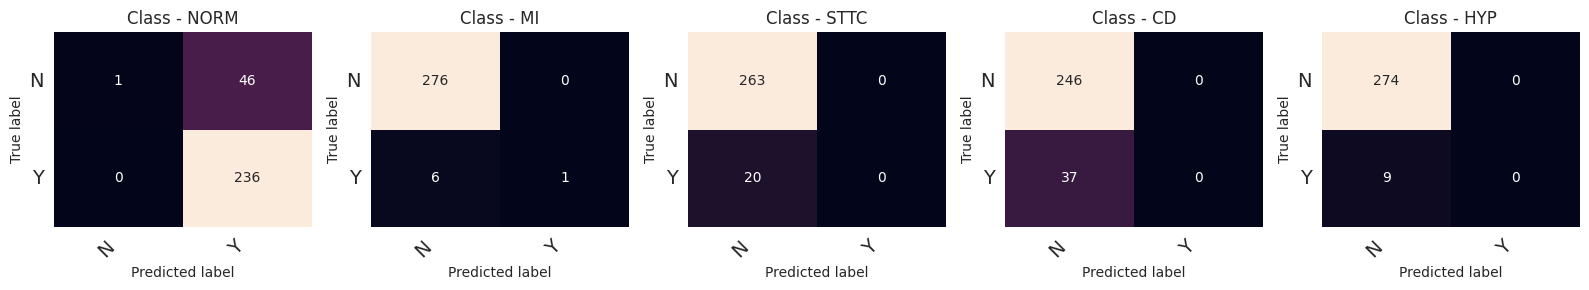

              precision    recall  f1-score   support

        NORM       0.84      1.00      0.91       236
          MI       1.00      0.14      0.25         7
        STTC       0.00      0.00      0.00        20
          CD       0.00      0.00      0.00        37
         HYP       0.00      0.00      0.00         9

   micro avg       0.84      0.77      0.80       309
   macro avg       0.37      0.23      0.23       309
weighted avg       0.66      0.77      0.70       309
 samples avg       0.84      0.81      0.82       309



In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(16, 3))

for axes, cfs_matrix, label in zip(ax.flatten(), sklearn.metrics.multilabel_confusion_matrix(Z_test, Z_pred_01), labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

fig.tight_layout()
plt.show()

print(sklearn.metrics.classification_report(Z_test, Z_pred_01, target_names=labels, zero_division=0))

## Confusion Matrix and Classification Report for model02

Second model uses metadata dataset X and ECG curves dataset Y.

The results are better compared to model01. I am able to predict all labels. By assessing the metric Precission, I am able to predict all labels well. On the other side looking at the Recall metric, I am not successful for classifying labels CD and HYP respectively. This could be a problem.

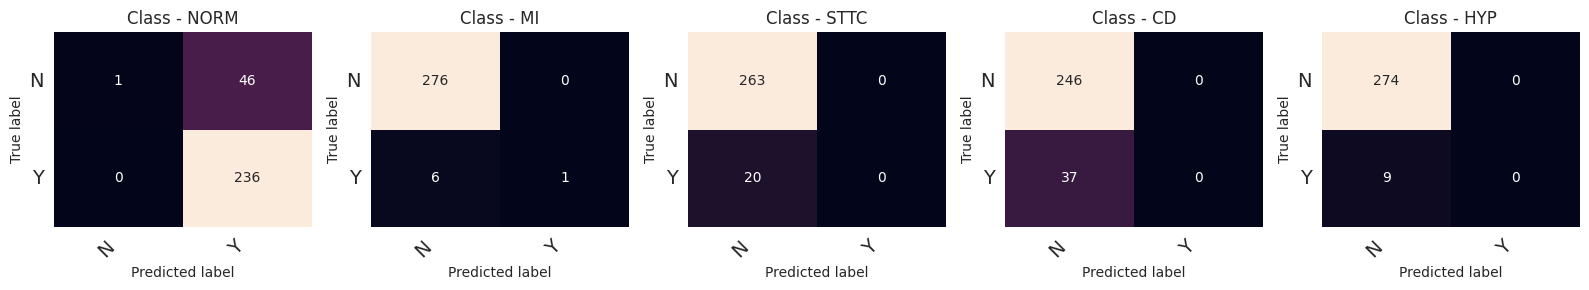

              precision    recall  f1-score   support

        NORM       0.84      1.00      0.91       236
          MI       1.00      0.14      0.25         7
        STTC       0.00      0.00      0.00        20
          CD       0.00      0.00      0.00        37
         HYP       0.00      0.00      0.00         9

   micro avg       0.84      0.77      0.80       309
   macro avg       0.37      0.23      0.23       309
weighted avg       0.66      0.77      0.70       309
 samples avg       0.84      0.81      0.82       309



In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(16, 3))

for axes, cfs_matrix, label in zip(ax.flatten(), sklearn.metrics.multilabel_confusion_matrix(Z_test, Z_pred_02), labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

fig.tight_layout()
plt.show()

print(sklearn.metrics.classification_report(Z_test, Z_pred_02, target_names=labels, zero_division=0))

## Confusion Matrix and Classification Report for model03

In the model03 I tried to use a data augmentation before using them for training model. I hoped this will help me to improve model02.

As you can see I was not wery successful. The Precission metric looks a bit better, bud the Recall is noticeably worse. I consider the Recall metric more significant for this type of classification than Precision metric.

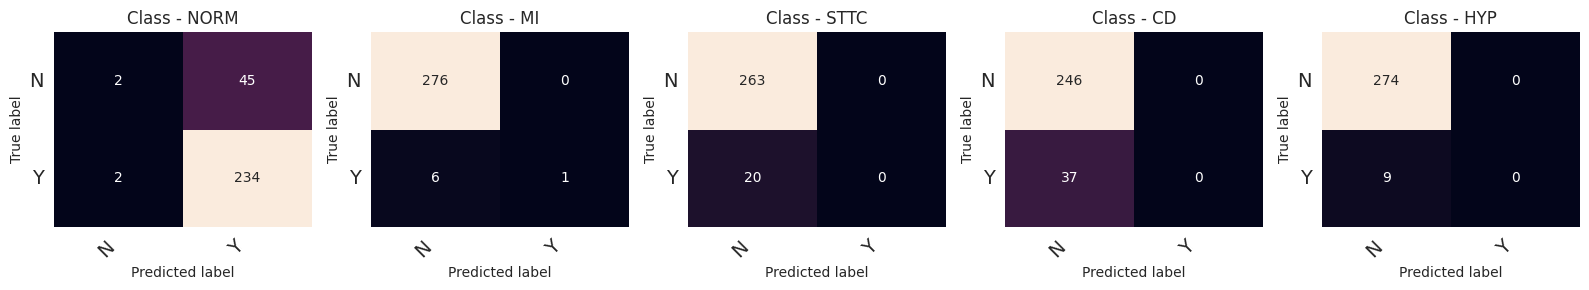

              precision    recall  f1-score   support

        NORM       0.84      0.99      0.91       236
          MI       1.00      0.14      0.25         7
        STTC       0.00      0.00      0.00        20
          CD       0.00      0.00      0.00        37
         HYP       0.00      0.00      0.00         9

   micro avg       0.84      0.76      0.80       309
   macro avg       0.37      0.23      0.23       309
weighted avg       0.66      0.76      0.70       309
 samples avg       0.83      0.80      0.81       309



In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(16, 3))

for axes, cfs_matrix, label in zip(ax.flatten(), sklearn.metrics.multilabel_confusion_matrix(Z_test, Z_pred_03), labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

fig.tight_layout()
plt.show()

print(sklearn.metrics.classification_report(Z_test, Z_pred_03, target_names=labels, zero_division=0))